In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, cv2, math
import datetime, pickle

In [2]:
#@title Curve function
from scipy.special import comb
import json
from PIL import Image
import matplotlib.path as mpath
import matplotlib.patches as mpatches

def bernstein_poly(i, n, t):
    """
     The Bernstein polynomial of n, i as a function of t
    """
    return comb(n, i) * (t**(n-i)) * (1 - t)**i


def bezier_curve(points, nTimes=1000):
    """
       Given a set of control points, return the
       bezier curve defined by the control points.

       points should be a list of lists, or list of tuples
       such as [ [1,1], 
                 [2,3], 
                 [4,5], ..[Xn, Yn] ]
        nTimes is the number of time steps, defaults to 1000

        See http://processingjs.nihongoresources.com/bezierinfo/
    """

    nPoints = len(points)
    xPoints = np.array([p[0] for p in points])
    yPoints = np.array([p[1] for p in points])

    t = np.linspace(0.0, 1.0, nTimes)

    polynomial_array = np.array(
        [bernstein_poly(i, nPoints-1, t) for i in range(0, nPoints)])

    xvals = np.dot(xPoints, polynomial_array)
    yvals = np.dot(yPoints, polynomial_array)

    return xvals, yvals

def plot_curve_using_control_points(img, control_points):
    # Create Bezier curve
    codes = [mpath.Path.MOVETO] + [mpath.Path.CURVE4]*(len(control_points)-1)
    path = mpath.Path(control_points, codes)

    # Plot the Bezier curve

    patch = mpatches.PathPatch(path, facecolor='none')

    #x, y = zip(*control_points)
    #plt.scatter(x, y)

    #im = Image.open(img_path)

    # Create figure and axes
    ax = plt.gca()

    # Display the image
    ax.imshow(img)

    # Add the patch to the Axes
    ax.add_patch(patch)

    return plt.gcf()


In [3]:
# Label imports
label = pd.read_csv('bezier.csv', index_col=0)
label.head()

,path,x_1,x_2,x_3,x_4,y_1,y_2,y_3,y_4
0,0.jpeg,440,431,436,384,439,361,252,220
1,10020.jpeg,493,497,465,424,438,345,219,191
2,10080.jpeg,426,428,445,417,370,308,225,168
3,10140.jpeg,484,500,523,487,383,291,233,186
4,1020.jpeg,502,480,396,456,399,314,211,177


In [4]:
root_img_dir = 'final_img/'


In [5]:
# imgs import
img_paths = label['path'].values

img_array_list = []
for img in img_paths:
  img = cv2.imread(root_img_dir+img)
  img_array_list.append(img)

X = np.asarray(img_array_list).astype('int32')

In [6]:
y_x = label[[f'x_{i+1}' for i in range(4)]].values
y_y = label[[f'y_{i+1}' for i in range(4)]].values

In [7]:
y_x_mean, y_y_mean = y_x.mean(), y_y.mean()
y_x_std, y_y_std = y_x.std(), y_y.std()
print('mean : ', y_x_mean, y_y_mean)
print('std : ', y_x_std, y_y_std)

mean :  380.0894495412844 282.77599388379207
std :  60.207608041325244 88.18947390419355


In [8]:
y_x = (y_x - y_x_mean)/y_x_std
y_y = (y_y - y_y_mean)/y_y_std

In [9]:
y_x.shape
y=np.hstack([y_x, y_y])

In [10]:
X.shape, y.shape

((327, 500, 800, 3), (327, 8))

In [11]:
# save data as tfds
data = tf.data.Dataset.from_tensor_slices((X, y))
tf.data.experimental.save(data, f'bezz_xy_scaled')

Instructions for updating:
Use `tf.data.Dataset.save(...)` instead.


In [13]:
# load data
data = tf.data.experimental.load('bezz_xy_scaled')
data = data.shuffle(200).batch(8)

In [14]:
# data preprocessing
train_n = int(len(data)*0.80)
print(f'train data have {train_n} batches and val data have {len(data)-train_n} batches...')

train_data = data.take(train_n)
val_data = data.skip(train_n)

train_data = train_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

train data have 32 batches and val data have 9 batches...


In [16]:
# model

input = tf.keras.Input(shape=(500,800,3))
res = layers.Rescaling(1./255)(input)
eff = tf.keras.applications.efficientnet_v2.EfficientNetV2S(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax',
    include_preprocessing=True
)

eff.trainable=False
for l in eff.layers[:-15]:
  l.trainable=False

meff = eff(input, training=False)
meff = layers.Dropout(0.005)(meff)

c1 = layers.Conv1D(1, 4, activation=None)(meff)
c1 = layers.LeakyReLU(alpha=0.01)(c1)
c1 = tf.squeeze(c1, -1)
c1 = layers.LSTM(32, activation=None, return_sequences=True)(c1)
c1 = layers.LeakyReLU(alpha=0.01)(c1)
c1 = layers.LSTM(32, activation='tanh', return_sequences=True)(c1)
c1 = layers.LSTM(4, activation='tanh', return_sequences=False)(c1)
c1 = layers.Dense(4, activation=None)(c1)


c2 = layers.Conv1D(1, 4, activation=None)(meff)
c2 = layers.LeakyReLU(alpha=0.01)(c2)
c2 = tf.squeeze(c2, -1)
c2 = layers.LSTM(32, activation=None, return_sequences=True)(c2)
c2 = layers.LeakyReLU(alpha=0.01)(c2)
c2 = layers.LSTM(32, activation='tanh', return_sequences=True)(c2)
c2 = layers.LSTM(4, activation='tanh', return_sequences=False)(c2)
c2 = layers.Dense(4, activation=None)(c2)


c1 = layers.concatenate([c1, c2])
model = models.Model(input, c1)
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='huber')

epochs=10
hp = model.fit(train_data, validation_data=val_data, epochs=epochs)

def scheduler(epoch, lr):
  if epoch < 42:
    return lr
  else:
    return lr *tf.math.exp(-0.04)

lr = tf.keras.callbacks.LearningRateScheduler(
    scheduler, verbose=0
)
epochs=80
eff.trainable=True

for l in eff.layers[:-11]:
  l.trainable=False

model.summary()
#model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae')
h = model.fit(train_data, validation_data=val_data, epochs=epochs, callbacks=[lr])

plt.figure(figsize=(20,5.1))
plt.plot(list(range(1,epochs+1)), h.history['loss'], label='train loss')
plt.plot(list(range(1,epochs+1)), h.history['val_loss'], label='val loss')
plt.grid(True)
plt.legend();
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

82420632/82420632 [==============================] - 1829s 22us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 500, 800, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficientnetv2-s (Functional)  (None, None, None,   20331360    ['input_3[0][0]']                
                                1280)                                                             
                                                                                                  
 dropout (Dropout)              (None, 16, 25, 1280  0           ['efficientnetv2-s[0][0]']       
                         

: 

: 

In [ ]:
def scheduler(epoch, lr):
  if epoch < 4:
    return 0.001
  else:
    return lr *tf.math.exp(-0.04)

lr = tf.keras.callbacks.LearningRateScheduler(
    scheduler, verbose=0
)
h = model.fit(train_data, validation_data=val_data, epochs=20, callbacks=[lr])

Epoch 1/20
32/32 [==============================] - 12s 375ms/step - loss: 0.0095 - val_loss: 0.0610 - lr: 0.0010
Epoch 2/20
32/32 [==============================] - 12s 383ms/step - loss: 0.0132 - val_loss: 0.0673 - lr: 0.0010
Epoch 3/20
32/32 [==============================] - 12s 375ms/step - loss: 0.0246 - val_loss: 0.0806 - lr: 0.0010
Epoch 4/20
32/32 [==============================] - 12s 366ms/step - loss: 0.0432 - val_loss: 0.0829 - lr: 0.0010
Epoch 5/20
32/32 [==============================] - 12s 363ms/step - loss: 0.0392 - val_loss: 0.0767 - lr: 9.6079e-04
Epoch 6/20
32/32 [==============================] - 11s 360ms/step - loss: 0.0321 - val_loss: 0.0720 - lr: 9.2312e-04
Epoch 7/20
32/32 [==============================] - 12s 361ms/step - loss: 0.0277 - val_loss: 0.0717 - lr: 8.8692e-04
Epoch 8/20
32/32 [==============================] - 12s 370ms/step - loss: 0.0249 - val_loss: 0.0670 - lr: 8.5214e-04
Epoch 9/20
32/32 [==============================] - 12s 373ms/step - los

In [ ]:
model.save('/content/drive/MyDrive/offroad/best_model.h5')
model.save('/content/drive/MyDrive/offroad/best_model')

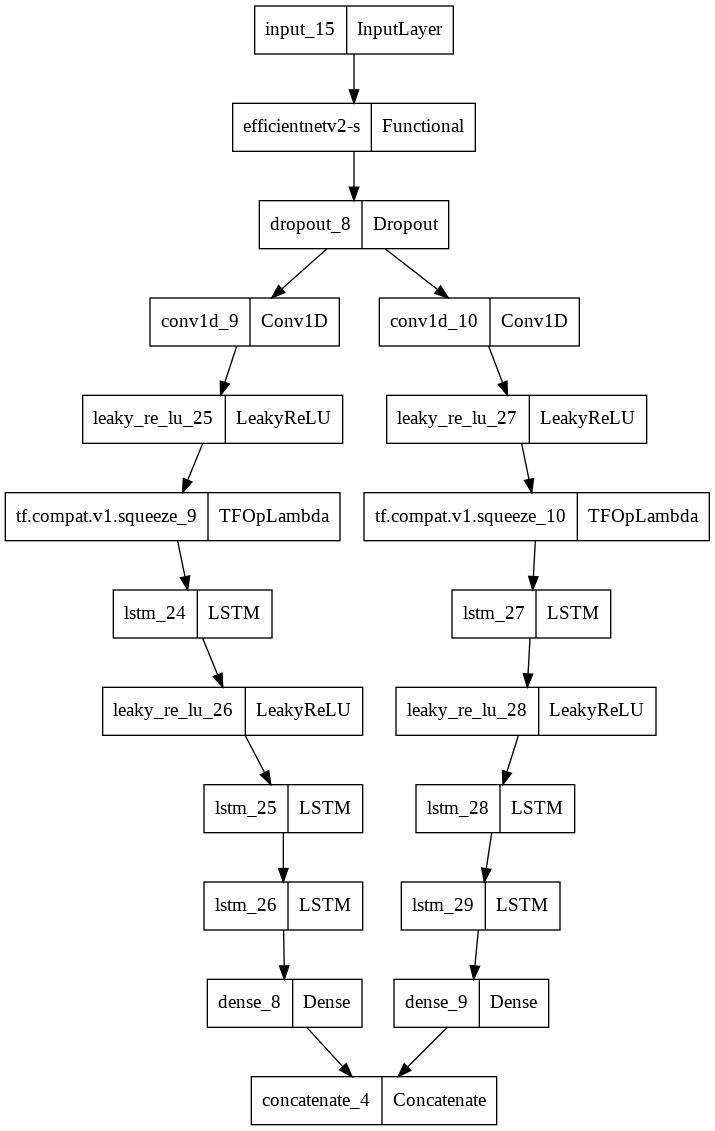

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='/content/drive/MyDrive/offroad/final_model.png')

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/offroad/best_model')

In [ ]:
#mean :  380.0894495412844 310.75
#std :  60.207608041325244 69.85833880074733
from keras.utils import plot_model
plot_model(model, to_file='/content/drive/MyDrive/offroad/final_model.png')

In [ ]:
def get_pred(model, img):
  img = cv2.resize(img, (800, 500))
  img = np.expand_dims(img, axis=0)
  pred = model.predict(img, verbose=0)[0]
  assert len(pred) == 8, print('length of pred is not 8')
  x, y = pred[:4], pred[4:]
  x = (x*61)+380
  y = (y*89)+280
  x = x.astype('uint32')
  y = y.astype('uint32')
  img = np.squeeze(img, axis=0)
  points = list(zip(x, y))
  #for x, y in points:
    #cv2.circle(img, (x,y), 4, (255,255,255), -1)
  X, Y = bezier_curve(points, nTimes=500)
 
  xp, yp = None, None
  for x, y in zip(X, Y):
    if not xp:
      xp, yp = x, y
      continue
    cv2.line(img, (int(xp), int(yp)), (int(x), int(y)), (255,255,255), 3)
    xp, yp = x, y

  return img

In [ ]:
f = get_pred(model, cv2.imread('/content/drive/MyDrive/offroad/tf_data/final_img/0.jpeg'))

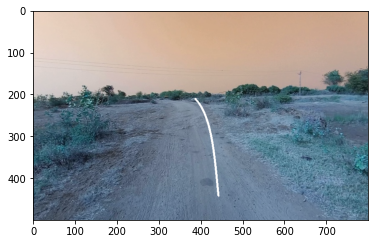

In [ ]:
plt.imshow(f)

In [1]:
import tensorflow as tf

In [3]:
!python

In [ ]:
v = cv2.VideoCapture('/content/drive/MyDrive/offroad/test.avi')
out = cv2.VideoWriter('/content/drive/MyDrive/offroad/test_output.avi', cv2.VideoWriter_fourcc(*'DIVX'), 15, (800,500))

while v.isOpened():
  cap, f = v.read()
  if cap:
    f = get_pred(model, f)
    out.write(f)
    
  else:
    break

out.release()
v.release()
